# NST Part II Physics - Computational Exercises Exercise 2: Integration and Vectorisation
I wrote a Monte-Carlo integrator `MCIntegrator`. The class
takes a `FunctionHolder` object and uses Monte-Carlo methods to integrate
it over a cuboidal region. I wrote it as an external class so that we 
could reuse the class to integrate other functions; rather than having to 
copy and paste the code we would be able to create another `FunctionHolder`
object and feed it into the `MCIntegrator` object. The `MCIntegrator` class
supports integrating both vectorised and non-vectorised functions (as 
defined in the `FunctionHolder` class).

A similar class `SPIntegrator` was also created for quadrature integration 
using SciPy.

In [ ]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
from abc import ABC, abstractmethod
import scipy.integrate

class FunctionHolder(ABC):
    """Abstract class to wrap functionality for functions to be integrated.
    Used by MCIntegrator and SPIntegrator."""
    
    @property
    @abstractmethod
    def ndims(self):
        """The dimensionality of the input vector x."""
        pass

    @property
    @abstractmethod
    def is_vectorised(self):
        """A property to be set by the child class. True if `function` can
        accept multiple input arguments as a vector, or in the case of an
        N-dimensional function, whether the function can accept a NxM matrix
        input and return a M-dimensional vector."""
        pass

    @abstractmethod
    def function(self, x):
        """The function to be implemented."""
        pass

class MCIntegrator():
    """Class to integrate a function specified by a FunctionHolder object
    over a cuboidal region using Monte-Carlo method."""

    def __init__(self, fn_holder, region_min, region_max):
        self.fn_holder = fn_holder
        self.ndims = fn_holder.ndims
        self.region_min = np.array([region_min])
        self.region_max = np.array([region_max])

        self.fs = None
        self.integral = None
        self.sigma = None
        self.n = None

    def integrate(self, n):
        """Integrates the function using Monte-Carlo method with `n` samples."""
        self.sample(n)
        self._calculate_integral()
        self._calculate_sigma()
        
    def sample(self, n):
        """Samples the function from `n` points randomly sampled."""
        r_rand = np.random.rand(self.ndims, n)*(self.region_max.T - self.region_min.T) + self.region_min.T*np.ones([self.ndims,n])
        if self.fn_holder.is_vectorised:
            self.fs = self.fn_holder.function(r_rand)
        else:
            self.fs = np.array([self.fn_holder.function(x) for x in r_rand])

    def _calculate_integral(self):
        """Calculates the integral after the function has been sampled."""
        volume = (self.region_max - self.region_min).prod()
        self.integral = self.fs.mean() * volume

    def _calculate_sigma(self):
        """Calcualtes the error estimate after the function has been sampled."""
        volume = (self.region_max - self.region_min).prod()
        n = self.fs.shape[0]
        f_av = self.fs.mean()
        fsq_av = (self.fs**2).mean()
        self.sigma = volume * np.sqrt((fsq_av - f_av**2) / n)

class SPIntegrator():
    """Class to integrate a single variable function specified by a FunctionHolder
    object using the SciPy quadrature method."""

    def __init__(self, fn_holder, domain_min, domain_max):
        self.fn_holder = fn_holder
        if self.fn_holder.ndims != 1:
            raise ValueError('Multivariable functions are not supported.')

        self.domain_min = domain_min
        self.domain_max = domain_max

        self.integral = None

    def integrate(self):
        if self.fn_holder.is_vectorised:
            integrand = lambda x : self.fn_holder.function(x)
        else:
            integrand = lambda xs : [self.fn_holder.function(x) for x in xs]

        self.integral = scipy.integrate.quad(integrand, self.domain_min, self.domain_max)[0]
        return self.integral

## Core Task 1<br />Integrates the supplied function using the Monte-Carlo method.

We calculate the given integral using the `MCIntegrator` class.
We get an estimate of $537.1845166727726$ using $2.5 \times 10^7$ samples. In 
Figure 1 we show that the integral estimate converges to a value
of roughly 537, and we see that the errors decrease. In Figure 2, 
we plot the error estimates from the theoretical Monte-Carlo error and the 
error calculated from the standard deviation in multiple estimates. We find that
these produce similar estimates and we plot a $N^{1/2}$ fit against it to show that 
the error falls off as $N^{1/2}$.

Best estimate is 537.1965046021679.


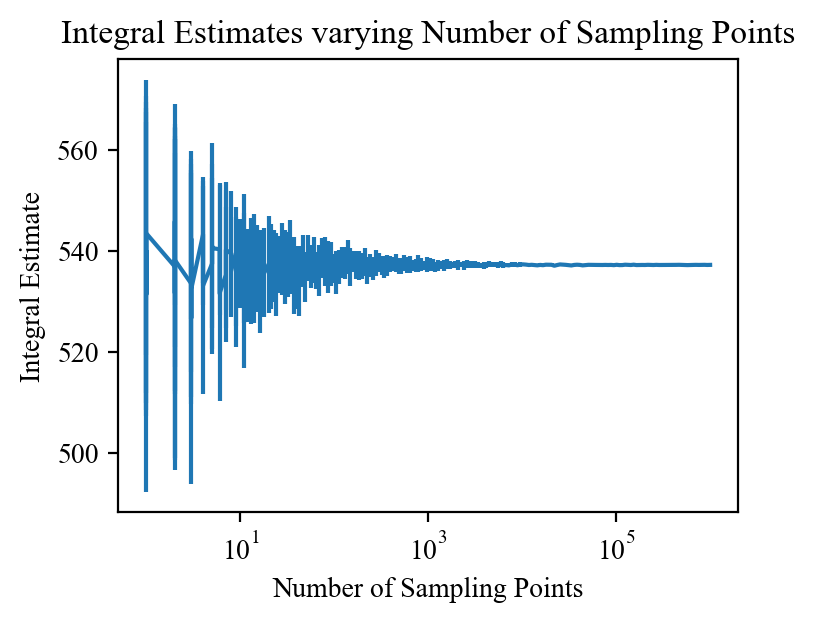

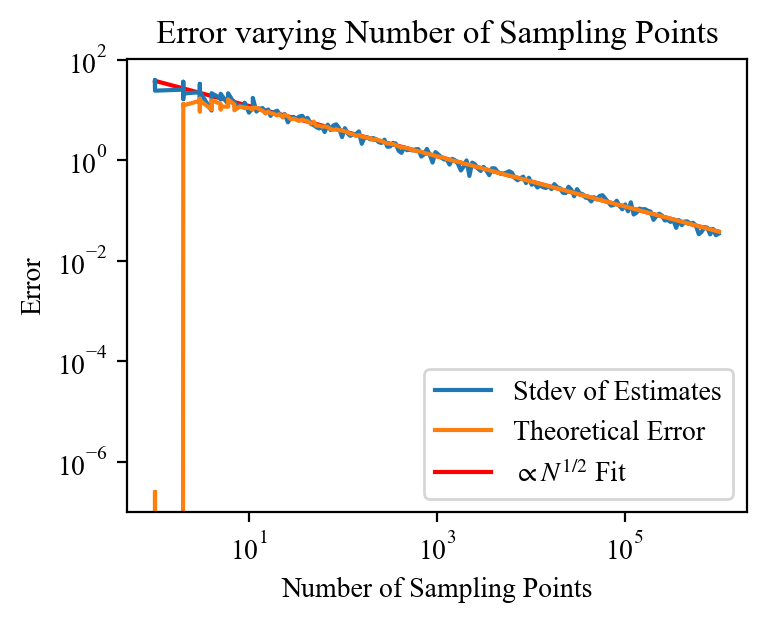

In [ ]:
from matplotlib import pyplot as plt
import matplotlib as mpl

# Set up our Integrator class.
# I wrote the integrator classes so that if we required to integrate multiple functions
# using Monte-Carlo method we wouldn't have to rewrite all the code.
class CoreTask1Function(FunctionHolder):
    ndims = 8
    is_vectorised = True

    def function(self, x):
        return 10**6 * np.sin(x.sum(axis=0))

integrator = MCIntegrator(CoreTask1Function(), [0]*8, [np.pi/8]*8)

# Create an array for the number of sampling points we use.
n_min = 0
n_max = 6
n_nums = 200
ns = np.round(np.logspace(n_min, n_max, n_nums)).astype(int)

# Iterate over different sampling values and compute an estimate with an error.
estimates = np.zeros([n_nums])
errors = np.zeros([n_nums])
theoretical_errors = np.zeros([n_nums])

n_iter = 25

for j in range(n_nums):
    n = ns[j]
    # print(f'Sampling {n} times...')

    ests = np.zeros([n_iter])
    sigmas = np.zeros([n_iter])

    for i in range(n_iter):
        integrator.integrate(n)
        ests[i] = integrator.integral
        sigmas[i] = integrator.sigma

    estimates[j] = ests.mean()
    errors[j] = ests.std()
    theoretical_errors[j] = sigmas.mean()

print(f'Best estimate is {estimates[-1]}.')

# Plot the estimates and their errors.
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['figure.dpi'] = 100

plt.figure(1, figsize=(4,3))
plt.errorbar(ns, estimates, errors)
plt.xscale('log')
plt.title('Integral Estimates varying Number of Sampling Points')
plt.xlabel('Number of Sampling Points')
plt.ylabel('Integral Estimate')

# Plot the errors as a function of N.
plt.figure(2, figsize=(4,3))
plt.plot(ns, errors, label='Stdev of Estimates')
plt.plot(ns, theoretical_errors, label='Theoretical Error')
plt.plot([ns[-1], 1], [theoretical_errors[-1], theoretical_errors[-1]*np.sqrt(ns[-1])], '-r', label='$\propto N^{1/2}$ Fit', zorder=-3, linewidth=1.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Error varying Number of Sampling Points')
plt.xlabel('Number of Sampling Points')
plt.ylabel('Error')
plt.legend()

plt.show()

## Supplementary Task 1<br />Vectorisation Speedup

We run the Monte-Carlo integral computation first with the vectorised methods of above and then with non-vectorised methods. For the non-vectorised method, instead of passing a single $N \times 8$ matrix to `np.sin`, we calculate the sum $x_0 + x_1 + \cdots + x_7$ through a `for` loop and pass the sum to `np.sin`. We repeat this $N$ times rather than passing a matrix argument to `np.sin`. We find that the vectorised method is over 10 times faster than the non-vectorised method.

In [ ]:
from timeit import timeit

# Do the Monte-Carlo integral with vectorised methods.
class CoreTask1Function(FunctionHolder):
    ndims = 8
    is_vectorised = True

    def function(self, x):
        return 10**6 * np.sin(x.sum(axis=0))
    
integrator = MCIntegrator(CoreTask1Function(), [0]*8, [np.pi/8]*8)
vectorised_time = timeit(lambda : integrator.integrate(50000), number=1000)

print(f'Vectorised time took{vectorised_time : 0.3f} seconds.')

# Do the Monte-Carlo integral without vectorised methods.
class CoreTask1FunctionNotVectorised(FunctionHolder):
    ndims = 8
    is_vectorised = False

    def function(self, x):
        summy = 0
        for xi in x:
            summy += xi
        return 10**6 * np.sin(summy)
    
integrator = MCIntegrator(CoreTask1FunctionNotVectorised(), [0]*8, [np.pi/8]*8)
nonvectorised_time = timeit(lambda : integrator.integrate(50000), number=1000)

print(f'Nonvectorised time took{nonvectorised_time : 0.3f} seconds.')

print(f'The vectorised method was{(nonvectorised_time / vectorised_time) : 0.3f} times faster.')

Vectorised time took 5.338 seconds.
Nonvectorised time took 54.235 seconds.
The vectorised method was 10.160 times faster.


## Core Task 2<br />Integrate to calculate the Cornu sprials.

## Supplementary Task 2<br />Calculate the Fresnel diffraction patterns from the Cornu spiral.

We calculate the Cornu spiral using SciPy quadrature integration.
Figure 1 plots the Cornu sprial from $u=-10$ to $u=10$, and the Fresnel
diffraction patterns for an aperture-screen distance of 30cm, 50cm and 100cm 
are in Figure 2, Figure 3 and Figure 4
respectively.

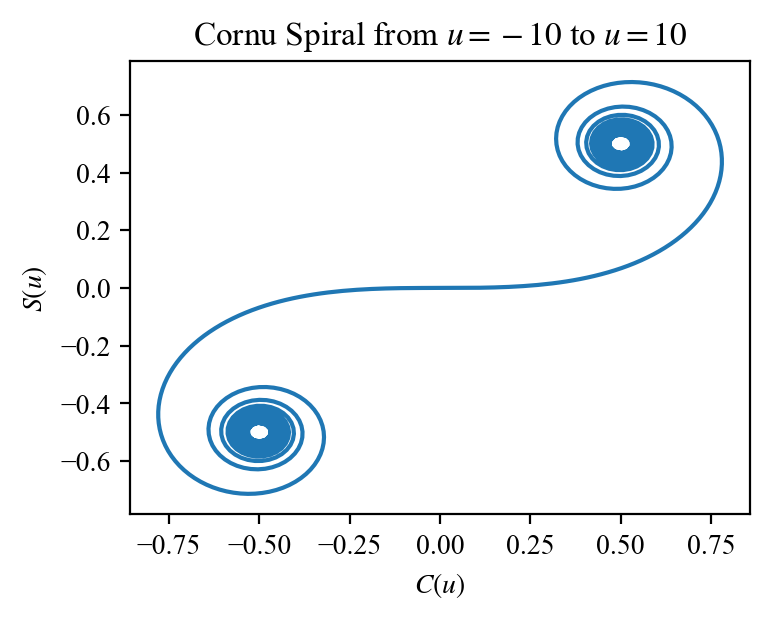

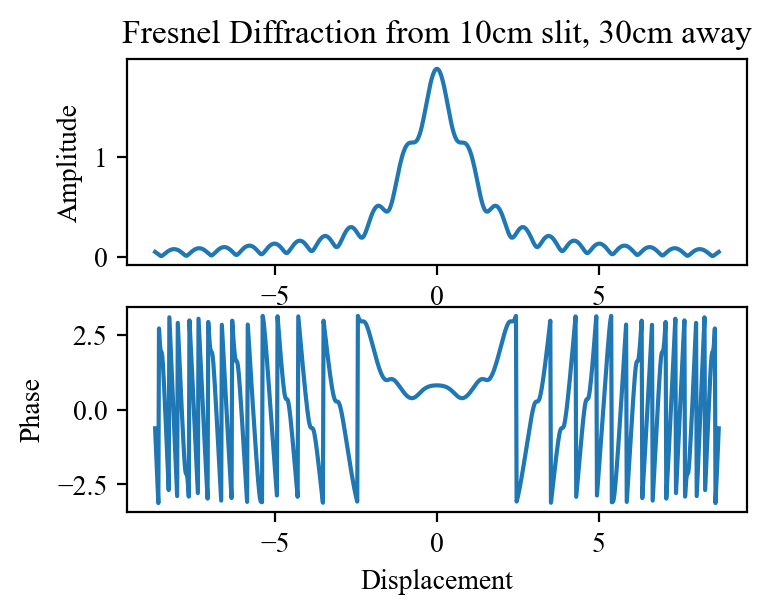

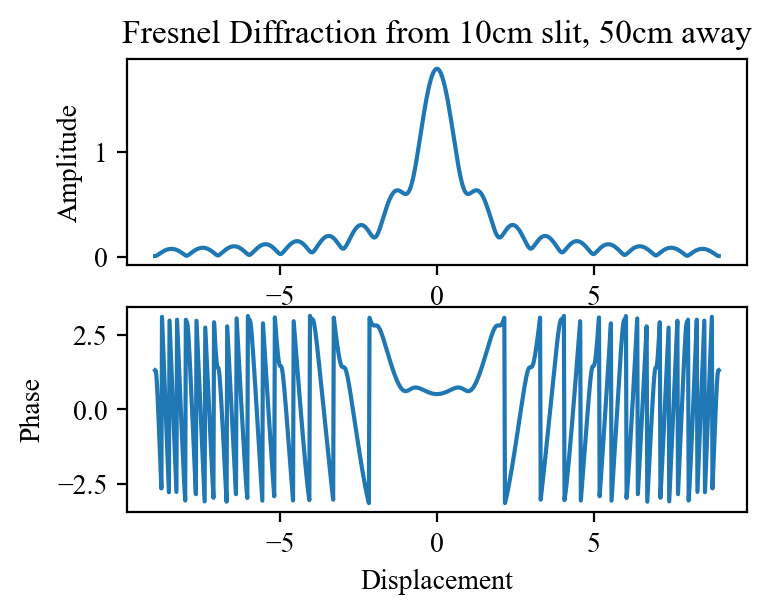

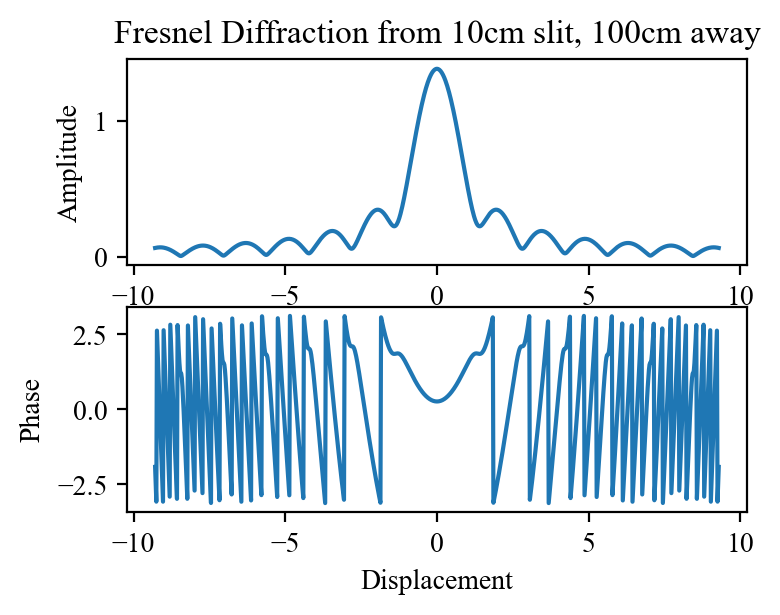

In [ ]:
# Set up our FunctionHolder classes for use in our SPIntegrator class.
# I wrote the integrator classes so that if we required to integrate multiple functions
# using this method we wouldn't have to rewrite all the code (although this was more 
# necessary in the Monte-Carlo case).
class RealCornuFunction(FunctionHolder):
    ndims = 1
    is_vectorised = True

    def function(self, x):
        return np.cos(np.pi * x**2 / 2)

class ImagCornuFunction(FunctionHolder):
    ndims = 1
    is_vectorised = True

    def function(self, x):
        return np.sin(np.pi * x**2 / 2)

# Use the SPIntegrator class to calculate the Cornu sprial values.
u_min = -10
u_max = 10
u_steps = 1000
us = np.linspace(u_min, u_max, u_steps)

cs = np.zeros([u_steps])
ss = np.zeros([u_steps])

for i in range(u_steps):
    u = us[i]
    real_integrator = SPIntegrator(RealCornuFunction(), 0, u)
    imag_integrator = SPIntegrator(ImagCornuFunction(), 0, u)
    cs[i] = real_integrator.integrate()
    ss[i] = imag_integrator.integrate()

# Plot the Cornu spiral.
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['figure.dpi'] = 100

plt.figure(1, figsize=(4,3))
plt.plot(cs,ss)
plt.title('Cornu Spiral from $u=-10$ to $u=10$')
plt.xlabel('$C(u)$')
plt.ylabel('$S(u)$')
# plt.savefig('core_task_2_fig_1.pdf', bbox_inches='tight')
# print('Generated core_task_2_fig_1.pdf.')

# Calculate the Diffraction Pattern
ds = [30, 50, 100]
fresnel_patterns = [None]*3
fresnel_xs = [None]*3

for i in range(len(ds)):
    d = ds[i]
    delta_u = np.sqrt(2/d) * 10
    delta_steps = int(np.round(delta_u * u_steps / (u_max - u_min)))
    u_lower = us[0:-delta_steps]
    index_lower = np.arange(0, u_steps-delta_steps)
    u_upper = us[delta_steps:]
    index_upper = np.arange(delta_steps, u_steps)
    fresnel_xs[i] = (u_upper + u_lower)/2.0
    fresnel_patterns[i] = cs[index_upper] - cs[index_lower] + 1j*(ss[index_upper] - ss[index_lower])

    # Plot the Diffraction Pattern
    fig, (ax1, ax2) = plt.subplots(2, figsize=(4,3))
    ax1.plot(fresnel_xs[i], np.abs(fresnel_patterns[i]))
    ax2.plot(fresnel_xs[i], np.angle(fresnel_patterns[i]))
    ax1.set_title(f'Fresnel Diffraction from 10cm slit, {ds[i]}cm away')
    ax1.set(ylabel='Amplitude')
    ax2.set(ylabel='Phase', xlabel='Displacement')
    # plt.savefig(f'core_task_2_fig_{i+2}.pdf', bbox_inches='tight')
    # print(f'Generated core_task_2_fig_{i+2}.pdf.')

#plt.show()